In [270]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import math

In [213]:
data = pd.read_csv('IDPHExport.csv')

In [214]:
data.head()

,CountyName,AdministeredCount,AdministeredCountChange,AdministeredCountRollAvg,PersonsFullyVaccinated,Report_Date,PctVaccinatedPopulation
0,Illinois,1,1,0,0,12/15/20 0:00,0.0
1,Illinois,1995,1994,285,0,12/16/20 0:00,0.0
2,Illinois,13035,11040,1862,0,12/17/20 0:00,0.0
3,Illinois,34047,21012,4864,0,12/18/20 0:00,0.0
4,Illinois,47297,13250,6757,0,12/19/20 0:00,0.0


In [215]:
data.dtypes

CountyName                   object
AdministeredCount             int64
AdministeredCountChange       int64
AdministeredCountRollAvg      int64
PersonsFullyVaccinated        int64
Report_Date                  object
PctVaccinatedPopulation     float64
dtype: object

In [216]:
data["Report_Date"] = pd.to_datetime(data["Report_Date"])

In [217]:
data = data[['AdministeredCount', 'AdministeredCountChange','PersonsFullyVaccinated', 'Report_Date']]



In [218]:
data.columns

Index(['AdministeredCount', 'AdministeredCountChange',
       'PersonsFullyVaccinated', 'Report_Date'],
      dtype='object')

In [219]:
data = data.rename(columns={'AdministeredCount':'total doses to date',
                     'AdministeredCountChange':'daily new doses',
                     'PersonsFullyVaccinated':'total people with two doses', 
                     'Report_Date': "date"})

In [220]:
data.head()

,total doses to date,daily new doses,total people with two doses,date
0,1,1,0,2020-12-15
1,1995,1994,0,2020-12-16
2,13035,11040,0,2020-12-17
3,34047,21012,0,2020-12-18
4,47297,13250,0,2020-12-19


In [221]:
for index, row in data.iterrows():
    if index == 0:
        data.loc[index, "new second doses"] = 0
    else:
        previous = index - 1
        data.loc[index, "new second doses"] = data.loc[index, "total people with two doses"] - data.loc[previous, "total people with two doses"]
    
    data.loc[index, "new first doses"] = data.loc[index, "daily new doses"] - data.loc[index, "new second doses"]
    

In [222]:
data["new second doses"] = data["new second doses"].astype("int64")
data["new first doses"] = data["new first doses"].astype("int64")

In [223]:
data["first dose 7 day rolling average"] = data.rolling(window=7, on="date", min_periods=1)["new first doses"].mean()
data["second dose 7 day rolling average"] = data.rolling(window=7, on="date")["new second doses"].mean()


In [224]:
data.columns

Index(['total doses to date', 'daily new doses', 'total people with two doses',
       'date', 'new second doses', 'new first doses',
       'first dose 7 day rolling average',
       'second dose 7 day rolling average'],
      dtype='object')

In [225]:
data['date'][0]

Timestamp('2020-12-15 00:00:00')

In [226]:
xticks=[]

In [227]:
date_list = data["date"].tolist()

In [228]:
x = date_list[0]

In [229]:
while x in date_list:
    xticks.append(x.strftime('%m/%d'))
    x = x+timedelta(days=7)

In [280]:
#yticks
max_y = data[["new first doses", "new second doses"]].max().max()
max_ytick = int(math.ceil(max_y / 10000)) * 10000
yticks = np.arange(10000, max_ytick+1, 10000)
ytick_labels = [f"{int(y/1000)}k" for y in yticks]

In [281]:
ytick_labels

['10k', '20k', '30k', '40k', '50k', '60k', '70k']

In [253]:
bars1 = data["new first doses"]
bars2 = data["new second doses"]

r1 = np.arange(len(bars1))
r2 = [x + barwidth for x in r1]

r_2ndrolling = np.arange(22.5,len(bars1)+.5)
data_2ndrolling = data["second dose 7 day rolling average"].drop(np.arange(22))

In [255]:
data.loc[data["second dose 7 day rolling average"]==0,:]

,total doses to date,daily new doses,total people with two doses,date,new second doses,new first doses,first dose 7 day rolling average,second dose 7 day rolling average
6,67324,12509,0,2020-12-21,0,12509,9617.714286,0.0
7,76968,9644,0,2020-12-22,0,9644,10995.285714,0.0
8,87617,10649,0,2020-12-23,0,10649,12231.714286,0.0
9,93869,6252,0,2020-12-24,0,6252,11547.714286,0.0
10,95434,1565,0,2020-12-25,0,1565,8769.571429,0.0
11,96886,1452,0,2020-12-26,0,1452,7084.142857,0.0
12,98064,1178,0,2020-12-27,0,1178,6178.428571,0.0
13,103832,5768,0,2020-12-28,0,5768,5215.428571,0.0
14,122540,18708,0,2020-12-29,0,18708,6510.285714,0.0
15,143623,21083,0,2020-12-30,0,21083,8000.857143,0.0


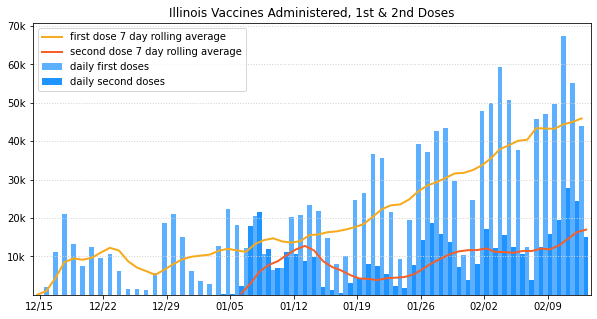

In [287]:
fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(111)

plt.grid(True, color = "#D3D3D3", axis='y', linewidth = "1", linestyle=':')
plt.title("Illinois Vaccines Administered, 1st & 2nd Doses")

barwidth = .5

plt.bar(r1, bars1, color='#5CB0FF', width=barwidth, label='daily first doses')
plt.bar(r2, bars2, color='#1F93FF', width=barwidth, label='daily second doses')

plt.plot(r1, data["first dose 7 day rolling average"], linewidth=2, color='#F6AA1C', label = "first dose 7 day rolling average")
plt.plot(r_2ndrolling, data_2ndrolling, linewidth=2, color='#F65F28', label = "second dose 7 day rolling average")

plt.xticks([r*7 + (barwidth/2) for r in range(len(xticks))], xticks)
plt.yticks(yticks, ytick_labels)
plt.xlim(-.5,max(r1)+1)

plt.legend()
plt.show()